In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 읽기
df = pd.read_csv('/content/drive/MyDrive/dacon_SPADA/센터데이터/0816/clean/clean_review_df.csv')
an_df = pd.read_csv("/content/drive/MyDrive/dacon_SPADA/이상데이터/anomaly_review_data_0904.csv")

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# 데이터 전처리
# 특정 가게에만 리뷰 5점을 남긴것, 시간은 랜덤
# 별점 1점만 준것
an_df['REVIEW_TIME']= pd.to_datetime(an_df['REVIEW_TIME'])
an_df['LABEL']= 1
df['LABEL']= 0
df['REVIEW_TIME']= pd.to_datetime(df['REVIEW_TIME'])
df.drop(['Unnamed: 0'],axis=1,inplace=True)

# 5회 미만으로 등장한 CUST_ID를 필터링하여 삭제
# cust_id_counts = df['CUST_ID'].value_counts()
# df = df[df['CUST_ID'].isin(cust_id_counts[cust_id_counts >= 5].index)]
# df.reset_index(drop=True, inplace=True)

In [15]:
an_df

,SHOP_ID,CUST_ID,REVIEW_TIME,REVIEW_RANK,LABEL
0,3455,63653,2023-03-26 10:50:43,5,1
1,3455,63653,2023-03-27 21:01:57,5,1
2,3455,63653,2023-03-26 03:31:28,5,1
3,3455,63653,2023-03-15 23:53:16,5,1
4,3455,63653,2023-03-17 05:17:20,5,1
...,...,...,...,...,...
1464,14145,46250,2022-04-10 16:38:19,5,1
1465,14145,46250,2022-04-28 01:37:16,5,1
1466,14145,46250,2022-04-26 03:31:48,5,1
1467,14145,46250,2022-04-08 10:38:42,5,1


In [16]:
df

,SHOP_ID,CUST_ID,REVIEW_TIME,REVIEW_RANK,LABEL
0,1811,128249,2022-01-12 18:44:49,2,0
1,1811,152073,2022-01-15 22:49:56,5,0
2,1811,571186,2022-01-27 19:09:48,5,0
3,1811,309754,2022-02-11 19:51:56,5,0
4,1811,4371,2022-09-08 10:32:55,1,0
...,...,...,...,...,...
6607,14776,351333,2022-08-09 18:27:20,5,0
6608,14776,757143,2022-08-18 23:07:11,5,0
6609,14787,634284,2022-08-09 13:06:24,5,0
6610,14787,244945,2022-07-31 10:34:51,5,0


In [17]:
# 정상데이터와 이상 데이터 병합 및 시간으로 정렬
con_df = pd.concat([df,an_df])
con_df.sort_values(by=['REVIEW_TIME'],inplace=True)
con_df.reset_index(drop=True,inplace=True)

In [18]:
len(con_df), len(df) ,len(an_df)

(8081, 6612, 1469)

In [19]:
con_df

,SHOP_ID,CUST_ID,REVIEW_TIME,REVIEW_RANK,LABEL
0,2299,118430,2022-01-01 02:32:33,5,0
1,5499,217122,2022-01-01 10:54:40,5,0
2,7756,349123,2022-01-01 11:53:11,5,0
3,8098,296419,2022-01-01 12:21:39,5,0
4,4826,448579,2022-01-01 12:37:50,5,0
...,...,...,...,...,...
8076,13319,429817,2023-11-13 12:49:57,1,1
8077,13319,429817,2023-11-14 00:31:38,1,1
8078,14039,159355,2023-11-15 11:36:40,5,1
8079,14039,159355,2023-11-20 04:39:22,5,1


## LABEL 1(이상치)

In [22]:
label_1_ratio = con_df['LABEL'].mean()
print(f"LABEL 1 비율: {label_1_ratio * 100:.2f}%")

LABEL 1 비율: 18.18%


## Isolation Forest 튜닝



* 해당 Isolation Forest를 5폴드 교차검증한 결과 F1 Score가 가장 높은 최적의 오염 비율은 0.14였다. <br>
하지만 이상거래 탐지에 있어서 Recall이 높은 값이 중요하기 때문에 Recall이 높으면서, F1 Score가 높은 값을 튜닝해본 결과 오염 비율을 23%로 조정하는것이 낫다고 판단되어 23%로 수정하였다.


In [98]:
#isolation forest
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 정상 데이터와 허위 데이터를 결합
full_df = con_df.copy()

# REVIEW_TIME을 float로 변환하여 타임스탬프로 저장
full_df['REVIEW_TIME_TS'] = pd.to_datetime(full_df['REVIEW_TIME']).apply(lambda x: x.timestamp())

# 기존 features에 REVIEW_TIME_TS를 추가
features = [ 'SHOP_ID','CUST_ID', 'REVIEW_TIME_TS',"REVIEW_RANK"]

# Isolation Forest 모델 훈련 (Review Time 포함)
# 정확도를 위해
model = IsolationForest(contamination=0.23, random_state=42)  # 23%의 이상치 비율로 설정
full_df['predicted_anomaly'] = model.fit_predict(full_df[features])

# 이상치(-1)와 정상치(1)를 구분하여 predicted_anomaly 열에 표시
full_df['predicted_anomaly'] = full_df['predicted_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# 정확도 평가
accuracy = accuracy_score(full_df['LABEL'], full_df['predicted_anomaly'])
precision = precision_score(full_df['LABEL'], full_df['predicted_anomaly'])
recall = recall_score(full_df['LABEL'], full_df['predicted_anomaly'])
f1 = f1_score(full_df['LABEL'], full_df['predicted_anomaly'])

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


# predicted_anomaly와 동일
full_df['iso_pred'] = model.fit_predict(full_df[features])
full_df['iso_pred'] = full_df['iso_pred'].apply(lambda x: 1 if x == -1 else 0)

Accuracy: 0.8629
Precision: 0.5971
Recall: 0.7556
F1 Score: 0.6671


In [80]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 정상 데이터와 허위 데이터를 결합
full_df = con_df.copy()

# REVIEW_TIME을 float로 변환하여 타임스탬프로 저장
full_df['REVIEW_TIME_TS'] = pd.to_datetime(full_df['REVIEW_TIME']).apply(lambda x: x.timestamp())

# 기존 features에 REVIEW_TIME_TS를 추가
features = ['SHOP_ID', 'CUST_ID', 'REVIEW_TIME_TS', 'REVIEW_RANK']

# 오염 비율 범위 설정
contamination_rates = np.linspace(0.01, 0.3, 30)  # 0.01에서 0.3까지 30단계로 나눔

# 결과 저장을 위한 리스트
results = []

# StratifiedKFold를 사용하여 5-폴드 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 다양한 오염 비율에 대해 검증
for contamination in contamination_rates:
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []

    for train_index, test_index in skf.split(full_df[features], full_df['LABEL']):
        X_train, X_test = full_df.iloc[train_index][features], full_df.iloc[test_index][features]
        y_test = full_df.iloc[test_index]['LABEL']

        # Isolation Forest 모델 훈련
        model = IsolationForest(contamination=contamination, random_state=42)
        model.fit(X_train)

        # 테스트 데이터 예측
        y_pred = model.predict(X_test)

        # 이상치(-1)와 정상치(1)를 구분하여 predicted_anomaly로 변환
        y_pred = np.where(y_pred == -1, 1, 0)

        # 평가
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        # 결과 저장
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)

    # 각 오염 비율에 대한 평균 성능 저장
    results.append({
        'contamination': contamination,
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1': np.mean(f1_scores),
        'accuracy': np.mean(accuracy_scores)
    })

# 결과를 DataFrame으로 변환하여 확인
results_df = pd.DataFrame(results)

# 가장 높은 F1 Score를 가진 오염 비율 선택
best_f1_row = results_df.loc[results_df['f1'].idxmax()]

print(f"최적의 오염 비율 (F1 Score 기준): {best_f1_row['contamination']:.2f}")
print(f"Accuracy: {best_f1_row['accuracy']:.4f}")
print(f"Precision: {best_f1_row['precision']:.4f}")
print(f"Recall: {best_f1_row['recall']:.4f}")
print(f"F1 Score: {best_f1_row['f1']:.4f}")


최적의 오염 비율 (F1 Score 기준): 0.14
Accuracy: 0.8961
Precision: 0.7793
Recall: 0.6024
F1 Score: 0.6783


In [100]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras import layers, models
from datetime import datetime
full_df2 = con_df.copy()

# REVIEW_TIME을 UNIX 타임스탬프로 변환
# 코사인 유사도 추가
full_df2['REVIEW_TIME'] = full_df2['REVIEW_TIME'].apply(lambda x: int(pd.Timestamp(x).timestamp()))

# 데이터 전처리
# REVIEW_TIME을 포함한 SHOP_ID, CUST_ID, REVIEW_RANK, REVIEW_TIME 피처를 사용합니다.
features = full_df2[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIME']].values

# 데이터 정규화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# AutoEncoder 모델 정의
input_dim = features_scaled.shape[1]
encoding_dim = 3  # 잠재 변수의 크기 (임의로 3로 설정)
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 정상 데이터만을 사용하여 모델 학습
normal_data = features_scaled[full_df2['LABEL'] == 0]
X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=1)

# 전체 데이터에 대한 재구성
reconstructed = autoencoder.predict(features_scaled)

# 재구성 오류 계산 (MSE)
reconstruction_error = np.mean(np.power(features_scaled - reconstructed, 2), axis=1)

# 코사인 유사도 계산
cosine_sim = cosine_similarity(features_scaled, reconstructed).diagonal()

# 이상치 점수 계산
anomaly_score = reconstruction_error - cosine_sim

# 이상치 판별
thresholds = np.linspace(min(anomaly_score), max(anomaly_score), 50)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    predicted_anomalies = anomaly_score > threshold
    precision_scores.append(precision_score(full_df2['LABEL'], predicted_anomalies))
    recall_scores.append(recall_score(full_df2['LABEL'], predicted_anomalies))
    f1_scores.append(f1_score(full_df2['LABEL'], predicted_anomalies))

# 최적의 임계값 선택
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]

# 임계값 설정
k_threshold = best_threshold
predicted_anomalies = anomaly_score > k_threshold
full_df2['an_anomaly'] = predicted_anomalies

# 정확도 판단
accuracy = accuracy_score(full_df2['LABEL'], full_df2['an_anomaly'])
f1 = f1_score(full_df2['LABEL'], full_df2['an_anomaly'])
precision = precision_score(full_df2['LABEL'], full_df2['an_anomaly'])
recall = recall_score(full_df2['LABEL'], full_df2['an_anomaly'])

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f"k_threshold: {k_threshold}")

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8822 - val_loss: 0.7828
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7353 - val_loss: 0.6771
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.6560 - val_loss: 0.6196
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5969 - val_loss: 0.5865
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5737 - val_loss: 0.5670
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5426 - val_loss: 0.5543
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5442 - val_loss: 0.5446
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5209 - val_loss: 0.5354
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5178 - val_loss: 0.5255
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5089 - val_loss: 0.5142
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4993 - val_loss: 0.5025
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models

# 데이터 로드 및 전처리
full_df2 = con_df.copy()
full_df2['REVIEW_TIME'] = full_df2['REVIEW_TIME'].apply(lambda x: int(pd.Timestamp(x).timestamp()))

# 피처 설정
features = full_df2[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIME']].values

# 데이터 정규화 (MinMaxScaler로 변경)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# AutoEncoder 모델 정의
input_dim = features_scaled.shape[1]
encoding_dim = 6  # 잠재 변수의 크기를 늘림 (임의로 6로 설정)
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 정상 데이터만을 사용하여 모델 학습
normal_data = features_scaled[full_df2['LABEL'] == 0]
X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train, epochs=100, batch_size=64, validation_data=(X_val, X_val), verbose=1)

# 전체 데이터에 대한 재구성
reconstructed = autoencoder.predict(features_scaled)

# 재구성 오류 계산 (MSE)
reconstruction_error = np.mean(np.square(features_scaled - reconstructed), axis=1)

# 유클리드 거리 계산
euclidean_dist = np.linalg.norm(features_scaled - reconstructed, axis=1)

# 이상치 점수 계산 (유클리드 거리 사용)
anomaly_score = reconstruction_error + euclidean_dist

# 임계값 설정 및 평가
thresholds = np.linspace(min(anomaly_score), max(anomaly_score), 50)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    predicted_anomalies = anomaly_score > threshold
    precision_scores.append(precision_score(full_df2['LABEL'], predicted_anomalies))
    recall_scores.append(recall_score(full_df2['LABEL'], predicted_anomalies))
    f1_scores.append(f1_score(full_df2['LABEL'], predicted_anomalies))

# 최적의 임계값 선택
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]

# 최적의 임계값 적용
predicted_anomalies = anomaly_score > best_threshold
full_df2['an_anomaly'] = predicted_anomalies

# 성능 평가
accuracy = accuracy_score(full_df2['LABEL'], full_df2['an_anomaly'])
precision = precision_score(full_df2['LABEL'], full_df2['an_anomaly'])
recall = recall_score(full_df2['LABEL'], full_df2['an_anomaly'])
f1 = f1_score(full_df2['LABEL'], full_df2['an_anomaly'])

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f"k_threshold: {best_threshold}")


Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0895 - val_loss: 0.0330
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0260 - val_loss: 0.0063
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 - val_loss: 8.7271e-04
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.4406e-04 - val_loss: 6.9634e-04
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9111e-04 - val_loss: 5.8550e-04
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9823e-04 - val_loss: 5.0353e-04
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6729e-04 - val_loss: 4.7445e-04
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1331e-04 - val_loss: 4.1392e-04
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0537e-04 - val_loss: 3.8925e-04
Epoch 12/1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [103]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler

# 데이터 로드 및 전처리
full_df2 = con_df.copy()
full_df2['REVIEW_TIME'] = full_df2['REVIEW_TIME'].apply(lambda x: int(pd.Timestamp(x).timestamp()))

# 피처 설정
features = full_df2[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIME']].values

# 데이터 정규화
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 학습 및 검증 데이터 분할
normal_data = features_scaled[full_df2['LABEL'] == 0]
X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)

# Random Search 하이퍼파라미터 범위 설정
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 200],
    'encoding_dim': [3, 6, 10],
    'learning_rate': [0.001, 0.01, 0.0001]
}

# 하이퍼파라미터 샘플링
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# Best 성능 추적 변수 초기화
best_f1 = -1
best_params = None

# Random Search로 하이퍼파라미터 최적화
for params in param_list:
    print(f"Testing parameters: {params}")

    batch_size = params['batch_size']
    epochs = params['epochs']
    encoding_dim = params['encoding_dim']
    learning_rate = params['learning_rate']

    # AutoEncoder 모델 정의
    input_dim = X_train.shape[1]
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu')(input_layer)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = models.Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    # Early stopping 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 모델 학습
    history = autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, X_val), callbacks=[early_stopping], verbose=1)

    # 전체 데이터에 대해 재구성 오류 계산
    reconstructed = autoencoder.predict(features_scaled)
    reconstruction_error = np.mean(np.square(features_scaled - reconstructed), axis=1)

    # 이상치 판별 (임계값 설정)
    thresholds = np.linspace(min(reconstruction_error), max(reconstruction_error), 50)
    f1_scores = []

    for threshold in thresholds:
        predicted_anomalies = reconstruction_error > threshold
        f1 = f1_score(full_df2['LABEL'], predicted_anomalies)
        f1_scores.append(f1)

    # 최적 F1 Score 확인
    best_threshold_index = np.argmax(f1_scores)
    best_f1_score = f1_scores[best_threshold_index]

    if best_f1_score > best_f1:
        best_f1 = best_f1_score
        best_params = params
        print(f"New best F1 score: {best_f1:.4f} with params: {best_params}")

# 최종 결과 출력
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Hyperparameters: {best_params}")


Testing parameters: {'learning_rate': 0.001, 'epochs': 100, 'encoding_dim': 3, 'batch_size': 64}
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0960 - val_loss: 0.0379
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0336 - val_loss: 0.0204
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0178 - val_loss: 0.0093
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# REVIEW_TIME을 Unix 타임스탬프로 변환
full_df3 = con_df.copy()
full_df3['REVIEW_TIME'] = pd.to_datetime(full_df3['REVIEW_TIME'])
full_df3['REVIEW_TIMESTAMP'] = full_df3['REVIEW_TIME'].apply(lambda x: x.timestamp())

# 필요한 피처와 레이블 선택 (SHOP_ID, CUST_ID, REVIEW_RANK, REVIEW_TIMESTAMP)
features = full_df3[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIMESTAMP']].values
labels = full_df3['LABEL'].values  # 실제 레이블

# 데이터를 정규화
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# PyTorch 텐서로 변환
data = torch.tensor(features_scaled, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.int64)

# PyTorch DataLoader로 변환
batch_size = 16
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Autoencoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout 추가
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout 추가
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # 입력 데이터가 [0, 1]로 정규화되어 있다고 가정
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# 입력 차원과 인코딩 차원 설정
input_dim = data.shape[1]  # 입력 데이터의 차원 (SHOP_ID, CUST_ID, REVIEW_RANK, REVIEW_TIMESTAMP)
encoding_dim = 5  # 임의의 인코딩 차원 (조절 가능)
model = Autoencoder(input_dim, encoding_dim)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 모델 학습
num_epochs = 30

for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 이상 탐지
model.eval()

# 모든 데이터를 사용하여 재구성 오류 계산
with torch.no_grad():
    reconstructed = model(data)
    reconstruction_error = torch.mean((data - reconstructed) ** 2, dim=1)

# 다양한 임계값에 대한 Precision, Recall, F1 Score 계산
thresholds = np.linspace(min(reconstruction_error), max(reconstruction_error), 50)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    predicted_anomalies = reconstruction_error > threshold
    precision_scores.append(precision_score(labels, predicted_anomalies))
    recall_scores.append(recall_score(labels, predicted_anomalies))
    f1_scores.append(f1_score(labels, predicted_anomalies))

# 최적의 임계값 선택
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]

# 임계값 설정
p_threshold = best_threshold
predicted_anomalies = (reconstruction_error > p_threshold).numpy().astype(int)

# 평가 지표 계산
accuracy = accuracy_score(labels, predicted_anomalies)
precision = precision_score(labels, predicted_anomalies)
recall = recall_score(labels, predicted_anomalies)
f1 = f1_score(labels, predicted_anomalies)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"p_threshold: {p_threshold}")


# k_auto_pred 추가 - Kearas의 AutoEncoder로 이상치 판단된 것들에 라벨 1 추가
full_df3['p_auto_pred'] = (reconstruction_error > p_threshold).to(torch.int64)

Epoch [1/30], Loss: 0.0529
Epoch [2/30], Loss: 0.0523
Epoch [3/30], Loss: 0.1668
Epoch [4/30], Loss: 0.0446
Epoch [5/30], Loss: 0.0277
Epoch [6/30], Loss: 0.0029
Epoch [7/30], Loss: 0.0019
Epoch [8/30], Loss: 0.0250
Epoch [9/30], Loss: 0.0066
Epoch [10/30], Loss: 0.0103
Epoch [11/30], Loss: 0.0028
Epoch [12/30], Loss: 0.0017
Epoch [13/30], Loss: 0.0085
Epoch [14/30], Loss: 0.0121
Epoch [15/30], Loss: 0.0180
Epoch [16/30], Loss: 0.0035
Epoch [17/30], Loss: 0.0028
Epoch [18/30], Loss: 0.0105
Epoch [19/30], Loss: 0.0014
Epoch [20/30], Loss: 0.0006
Epoch [21/30], Loss: 0.0042
Epoch [22/30], Loss: 0.0306
Epoch [23/30], Loss: 0.0003
Epoch [24/30], Loss: 0.0076
Epoch [25/30], Loss: 0.0013
Epoch [26/30], Loss: 0.0062
Epoch [27/30], Loss: 0.0110
Epoch [28/30], Loss: 0.0029
Epoch [29/30], Loss: 0.0019
Epoch [30/30], Loss: 0.0013
Accuracy: 0.7945
Precision: 0.4278
Recall: 0.3873
F1 Score: 0.4066
p_threshold: 0.0017302478370079277


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# 데이터 로드 및 전처리
full_df3 = con_df.copy()
full_df3['REVIEW_TIME'] = pd.to_datetime(full_df3['REVIEW_TIME'])
full_df3['REVIEW_TIMESTAMP'] = full_df3['REVIEW_TIME'].apply(lambda x: x.timestamp())

# 피처와 레이블 설정
features = full_df3[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIMESTAMP']].values
labels = full_df3['LABEL'].values  # 실제 레이블

# 데이터 정규화 (MinMaxScaler 사용)
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# PyTorch 텐서로 변환
data = torch.tensor(features_scaled, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.int64)

# DataLoader로 변환
batch_size = 16
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# AutoEncoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),  # 드롭아웃 비율 조정
            nn.Linear(128, encoding_dim),
            nn.LeakyReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # 입력 데이터가 [0, 1]로 정규화되어 있다고 가정
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 모델 인스턴스 생성
input_dim = data.shape[1]  # 입력 데이터의 차원 (SHOP_ID, CUST_ID, REVIEW_RANK, REVIEW_TIMESTAMP)
encoding_dim = 5  # 인코딩 차원
model = Autoencoder(input_dim, encoding_dim)

# 손실 함수와 옵티마이저 정의
criterion = nn.HuberLoss()  # HuberLoss 사용
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 학습률 조정

# Early Stopping 설정
best_loss = float('inf')
patience = 10  # patience 설정 (연속적으로 개선되지 않으면 학습을 중단)
trigger_times = 0

# 모델 학습
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        inputs = batch[0]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Early Stopping 체크
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping activated.")
            break

# 이상 탐지
model.eval()

# 모든 데이터를 사용하여 재구성 오류 계산
with torch.no_grad():
    reconstructed = model(data)
    reconstruction_error = torch.mean((data - reconstructed) ** 2, dim=1).numpy()

# Precision-Recall 커브를 사용한 임계값 선택
precision, recall, thresholds = precision_recall_curve(labels, reconstruction_error)

# NaN 방지: 0으로 나눌 때 발생하는 에러 방지
f1_scores = np.divide(2 * (precision * recall), (precision + recall), where=(precision + recall) != 0)
f1_scores = np.nan_to_num(f1_scores)  # NaN을 0으로 변환

# 최적의 임계값 선택
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1 = f1_scores[best_threshold_index]

# 임계값 적용
predicted_anomalies = (reconstruction_error > best_threshold).astype(int)

# 평가 지표 계산
accuracy = accuracy_score(labels, predicted_anomalies)
precision = precision_score(labels, predicted_anomalies)
recall = recall_score(labels, predicted_anomalies)
f1 = f1_score(labels, predicted_anomalies)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Best Threshold: {best_threshold}")

# 예측 결과를 원본 데이터에 추가
full_df3['p_auto_pred'] = predicted_anomalies


Epoch [1/100], Loss: 0.0203
Epoch [2/100], Loss: 0.0033
Epoch [3/100], Loss: 0.0022
Epoch [4/100], Loss: 0.0017
Epoch [5/100], Loss: 0.0015
Epoch [6/100], Loss: 0.0013
Epoch [7/100], Loss: 0.0012
Epoch [8/100], Loss: 0.0011
Epoch [9/100], Loss: 0.0011
Epoch [10/100], Loss: 0.0010
Epoch [11/100], Loss: 0.0010
Epoch [12/100], Loss: 0.0009
Epoch [13/100], Loss: 0.0009
Epoch [14/100], Loss: 0.0009
Epoch [15/100], Loss: 0.0008
Epoch [16/100], Loss: 0.0008
Epoch [17/100], Loss: 0.0008
Epoch [18/100], Loss: 0.0008
Epoch [19/100], Loss: 0.0007
Epoch [20/100], Loss: 0.0007
Epoch [21/100], Loss: 0.0007
Epoch [22/100], Loss: 0.0007
Epoch [23/100], Loss: 0.0007
Epoch [24/100], Loss: 0.0006
Epoch [25/100], Loss: 0.0007
Epoch [26/100], Loss: 0.0006
Epoch [27/100], Loss: 0.0006
Epoch [28/100], Loss: 0.0006
Epoch [29/100], Loss: 0.0006
Epoch [30/100], Loss: 0.0006
Epoch [31/100], Loss: 0.0006
Epoch [32/100], Loss: 0.0006
Epoch [33/100], Loss: 0.0006
Epoch [34/100], Loss: 0.0006
Epoch [35/100], Loss: 0

In [ ]:
# XGBoost
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# REVIEW_TIME을 Unix 타임스탬프로 변환
full_df4 = con_df.copy()
full_df4['REVIEW_TIME'] = pd.to_datetime(full_df4['REVIEW_TIME'])
full_df4['REVIEW_TIMESTAMP'] = full_df4['REVIEW_TIME'].apply(lambda x: x.timestamp())

# 필요한 피처와 레이블 선택 (SHOP_ID, CUST_ID, REVIEW_RANK, REVIEW_TIMESTAMP)
features = full_df4[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIMESTAMP']]
labels = full_df4['LABEL']


# 이상 탐지를 위해 정상 데이터 일부를 사용해 '이상치'로 라벨링
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# XGBoost 모델 훈련
xgb_model = xgb.XGBClassifier(max_depth=3,  # 트리의 최대 깊이 줄이기
                              min_child_weight=5,  # 트리의 최소 샘플 가중치
                              subsample=0.8,  # 데이터 샘플링 비율
                              colsample_bytree=0.8)  # 피처 샘플링 비율
xgb_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = xgb_model.predict(X_test)

# 예측 결과 저장
full_df4['xgb_pred'] = xgb_model.predict(features)


# 평가 지표 계산
conf_matrix = confusion_matrix(labels, full_df4['xgb_pred'])
accuracy = accuracy_score(labels, full_df4['xgb_pred'])
precision = precision_score(labels, full_df4['xgb_pred'])
recall = recall_score(labels, full_df4['xgb_pred'])
f1 = f1_score(labels, full_df4['xgb_pred'])

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9850
Precision: 0.9700
Recall: 0.9469
F1 Score: 0.9583


In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# 데이터 준비
features = full_df4[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIMESTAMP']]
labels = full_df4['LABEL']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9406
Precision: 0.9697
Recall: 0.7157
F1 Score: 0.8235


In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# 데이터 준비
features = full_df4[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIMESTAMP']]
labels = full_df4['LABEL']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9443
Precision: 0.9745
Recall: 0.7316
F1 Score: 0.8358


# Ensemble 모델링


In [97]:
# ensemble
ensemble_df = con_df.copy()
ensemble_df['iso_pred'] = full_df['iso_pred']
ensemble_df['k_auto_pred'] = full_df2['k_auto_pred']
ensemble_df['p_auto_pred'] = full_df3['p_auto_pred']
ensemble_df['xgb_pred'] = full_df4['xgb_pred']

# And filter
ensemble_df['auto_pred'] = ensemble_df[['k_auto_pred', 'p_auto_pred']].mode(axis=1)[0]

# Vote
ensemble_df['an_label'] = ensemble_df[['iso_pred', 'auto_pred', 'xgb_pred']].mode(axis=1)[0]

KeyError: 'iso_pred'

In [ ]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 - Seaborn을 전체 이용한 산점도
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='CUST_ID',
    y='REVIEW_TIME',
    hue='LABEL',  # an_label에 따라 색상 구분
    style='an_label',  # an_label에 따라 스타일 구분
    palette=['blue', 'red'],  # 정상은 파란색, 이상치는 빨간색
    data=ensemble_df
)
plt.title('Scatter Plot of CUST_ID vs REVIEW_TIME  with Anomaly Labels')
plt.xlabel('CUST_ID')
plt.ylabel('Review Time (Timestamp)')
plt.legend(title='Anomaly Label')
plt.show()

# 시각화 - Seaborn을 이상데이터 이용한 산점도
target_df = ensemble_df[ensemble_df['LABEL'] == 1]
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='CUST_ID',
    y='REVIEW_TIME',
    hue='an_label',  # an_label에 따라 색상 구분
    style='an_label',  # an_label에 따라 스타일 구분
    palette=['blue', 'red'],  # 정상은 파란색, 이상치는 빨간색
    data=target_df
)
plt.title('Scatter Plot of CUST_ID vs REVIEW_TIME  with Anomaly Labels')
plt.xlabel('CUST_ID')
plt.ylabel('Review Time (Timestamp)')
plt.legend(title='Anomaly Label')
plt.show()

# 시각화 - Seaborn을 정상데이터 이용한 산점도
target_df = ensemble_df[ensemble_df['LABEL'] == 0]
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='CUST_ID',
    y='REVIEW_TIME',
    hue='an_label',  # an_label에 따라 색상 구분
    style='an_label',  # an_label에 따라 스타일 구분
    palette=['blue', 'red'],  # 정상은 파란색, 이상치는 빨간색
    data=target_df
)
plt.title('Scatter Plot of CUST_ID vs REVIEW_TIME  with Anomaly Labels')
plt.xlabel('CUST_ID')
plt.ylabel('Review Time (Timestamp)')
plt.legend(title='Anomaly Label')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
# 평가 지표 계산
accuracy = accuracy_score(ensemble_df['LABEL'], ensemble_df['an_label'])
precision = precision_score(ensemble_df['LABEL'], ensemble_df['an_label'])
recall = recall_score(ensemble_df['LABEL'], ensemble_df['an_label'])
f1 = f1_score(ensemble_df['LABEL'], ensemble_df['an_label'])
conf_matrix = confusion_matrix(ensemble_df['LABEL'], ensemble_df['an_label'])

# 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# 대구 전체 데이터로 테스트하기

In [ ]:
import pandas as pd
con_df = pd.read_csv('/content/drive/MyDrive/dacon_SPADA/센터데이터/0814/df_review.csv')
# con_df= con_df.drop(columns=['Unnamed: 0'])
con_df=con_df[:20000] # 메모리 부족으로 데이터 지도학습 데이터와 비슷한 양 추출
con_df['REVIEW_TIME'] = pd.to_datetime(con_df['REVIEW_TIME'])

In [ ]:
min(con_df['REVIEW_TIME'])

Timestamp('2022-01-01 00:16:20')

In [ ]:
#isolation forest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 정상 데이터와 허위 데이터를 결합
full_df = con_df.copy()

# REVIEW_TIME을 float로 변환하여 타임스탬프로 저장
full_df['REVIEW_TIME_TS'] = pd.to_datetime(full_df['REVIEW_TIME']).apply(lambda x: x.timestamp())

# 기존 features에 REVIEW_TIME_TS를 추가
features = [ 'SHOP_ID','CUST_ID', 'REVIEW_TIME_TS',"REVIEW_RANK"]

# Isolation Forest 모델 훈련 (Review Time 포함)
model = IsolationForest(contamination=0.3, random_state=42)  # 30%의 이상치 비율로 설정
full_df['predicted_anomaly'] = model.fit_predict(full_df[features])

# 이상치(-1)와 정상치(1)를 구분하여 predicted_anomaly 열에 표시
full_df['predicted_anomaly'] = full_df['predicted_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# predicted_anomaly와 동일
full_df['iso_pred'] = model.fit_predict(full_df[features])
full_df['iso_pred'] = full_df['iso_pred'].apply(lambda x: 1 if x == -1 else 0)
full_df.to_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_iso.csv')

In [ ]:
#keras autoencoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



# 정상 데이터와 허위 데이터를 결합
full_df2 = con_df.copy()

# 초 단위로 변환
full_df2['REVIEW_TIME'] = full_df2['REVIEW_TIME'].astype(int) / 10**9

# One-Hot Encoding
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(full_df2[['SHOP_ID', 'CUST_ID']]).toarray()

# 수치형 데이터 병합
X = np.hstack((encoded_columns, full_df2[['REVIEW_TIME', 'REVIEW_RANK']].values))

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# AutoEncoder 모델 정의
input_dim = X_scaled.shape[1]
encoding_dim = 64  # 잠재 공간 차원 (압축된 표현)

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)  # 중간 레이어 추가
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
encoded = layers.Dropout(0.2)(encoded)  # Dropout 추가
decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(input_layer, decoded)

# Early stopping 콜백 설정
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 컴파일 및 훈련
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=128, )

# 재구성 오류 계산
reconstructed = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - reconstructed), axis=1)


# 9. 임계값을 사용하여 이상치 탐지 (이상치 판단 기준 threshold 설정)
k_threshold =  0.18715090828476616 # 메모리 부족으로 나눠서 작업
full_df2['k_auto_pred'] = (reconstruction_error > k_threshold).astype(int)
full_df2.to_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_auto_k.csv')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# REVIEW_TIME을 Unix 타임스탬프로 변환
full_df3 = con_df.copy()
full_df3['REVIEW_TIME'] = pd.to_datetime(full_df3['REVIEW_TIME'])
full_df3['REVIEW_TIMESTAMP'] = full_df3['REVIEW_TIME'].apply(lambda x: x.timestamp())

# 필요한 피처와 레이블 선택 (SHOP_ID, CUST_ID, REVIEW_RANK, REVIEW_TIMESTAMP)
features = full_df3[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIMESTAMP']].values

# 데이터를 정규화
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# PyTorch 텐서로 변환
data = torch.tensor(features_scaled, dtype=torch.float32)

# PyTorch DataLoader로 변환
batch_size = 16
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Autoencoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout 추가
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout 추가
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # 입력 데이터가 [0, 1]로 정규화되어 있다고 가정
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# 입력 차원과 인코딩 차원 설정
input_dim = data.shape[1]  # 입력 데이터의 차원 (SHOP_ID, CUST_ID, REVIEW_RANK, REVIEW_TIMESTAMP)
encoding_dim = 5  # 임의의 인코딩 차원 (조절 가능)
model = Autoencoder(input_dim, encoding_dim)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 모델 학습
num_epochs = 30

for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 이상 탐지
model.eval()

# 모든 데이터를 사용하여 재구성 오류 계산

p_threshold = 0.0017302478370079277
with torch.no_grad():
    reconstructed = model(data)
    reconstruction_error = torch.mean((data - reconstructed) ** 2, dim=1)
predicted_anomalies = (reconstruction_error > p_threshold).numpy().astype(int)


# k_auto_pred 추가 - Kearas의 AutoEncoder로 이상치 판단된 것들에 라벨 1 추가
full_df3['p_auto_pred'] = (reconstruction_error > p_threshold).to(torch.int64)
full_df3.to_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_auto_p.csv')

In [ ]:
# XGBoost
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# REVIEW_TIME을 Unix 타임스탬프로 변환
full_df4 = con_df.copy()
full_df4['REVIEW_TIME'] = pd.to_datetime(full_df4['REVIEW_TIME'])
full_df4['REVIEW_TIMESTAMP'] = full_df4['REVIEW_TIME'].apply(lambda x: x.timestamp())

# 필요한 피처와 레이블 선택 (SHOP_ID, CUST_ID, REVIEW_RANK, REVIEW_TIMESTAMP)
features = full_df4[['SHOP_ID', 'CUST_ID', 'REVIEW_RANK', 'REVIEW_TIMESTAMP']]

# 예측 결과 저장
full_df4['xgb_pred'] = xgb_model.predict(features)
full_df4.to_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_xgb.csv')

In [ ]:
# ensemble
ensemble_df = con_df.copy()
ensemble_df['iso_pred'] = full_df['iso_pred']
ensemble_df['k_auto_pred'] = full_df2['k_auto_pred']
ensemble_df['p_auto_pred'] = full_df3['p_auto_pred']
ensemble_df['xgb_pred'] = full_df4['xgb_pred']

# And filter
ensemble_df['auto_pred'] = ensemble_df[['k_auto_pred', 'p_auto_pred']].mode(axis=1)[0]

# Vote
ensemble_df['an_label'] = ensemble_df[['iso_pred', 'auto_pred', 'xgb_pred']].mode(axis=1)[0]

In [ ]:
#대구로 이상탐지 데이터 저장
ensemble_df.to_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_ensemble.csv')

In [ ]:
filtered_df=ensemble_df.loc[ensemble_df['an_label']==1]

In [ ]:
# 탐지된 횟수 상위 5명 및 횟수
check_df=filtered_df['CUST_ID'].value_counts().head()
check_df

In [ ]:
# 리뷰 확인
for i in check_df.index:
    print('\n\n\n')
    print(con_df[con_df['CUST_ID']==i])
    print('\n\n\n')

In [ ]:
# 메모리 문제로 라벨 저장해둔 것 불러오기
import pandas as pd
full_df = pd.read_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_iso.csv')
full_df2 = pd.read_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_auto_k.csv')
full_df3 = pd.read_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_auto_p.csv')
full_df4 = pd.read_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_xgb.csv')

In [ ]:
con_df['iso_pred']=full_df['iso_pred']
con_df['k_auto_pred']=full_df2['k_auto_pred']
con_df['p_auto_pred']=full_df3['p_auto_pred']
con_df['xgb_pred']=full_df4['xgb_pred']

In [ ]:
con_df

,SHOP_ID,CUST_ID,REVIEW_TIME,REVIEW_RANK,iso_pred,k_auto_pred,p_auto_pred,xgb_pred
0,1812784,9953416,2023-07-28 21:55:02,5.0,1,1,0,1
1,1812784,7019864,2022-06-12 20:47:21,5.0,0,1,0,1
2,1812784,9548968,2022-04-19 19:58:51,5.0,1,1,0,1
3,1812784,9051036,2022-02-25 19:08:30,5.0,1,1,0,1
4,1812784,1186093,2022-04-11 13:12:46,5.0,1,1,0,1
...,...,...,...,...,...,...,...,...
19995,7574757,5547293,2022-01-27 20:30:29,5.0,0,1,0,1
19996,7574757,9087351,2022-02-26 09:36:47,5.0,0,1,0,1
19997,7574757,2577310,2022-05-10 12:32:47,5.0,0,1,0,1
19998,7574757,8016929,2022-02-26 17:08:57,5.0,0,1,0,1


In [ ]:

# And filter
con_df['auto_pred'] = con_df[['k_auto_pred', 'p_auto_pred']].mode(axis=1)[0]

# Vote
con_df['an_label'] = con_df[['iso_pred', 'auto_pred', 'xgb_pred']].mode(axis=1)[0]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


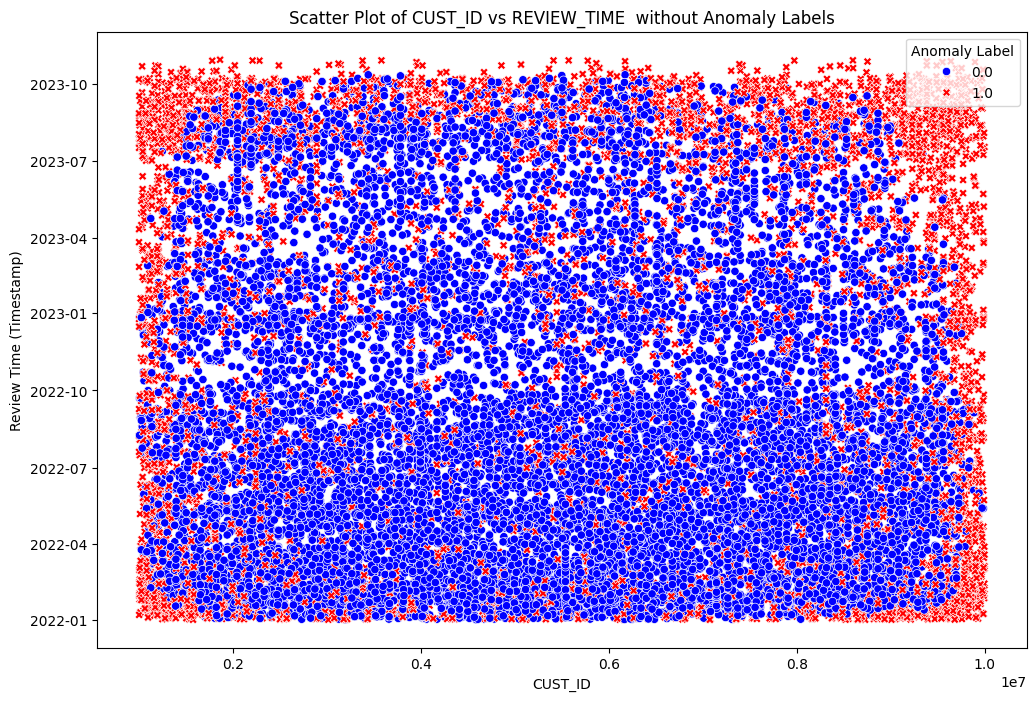

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


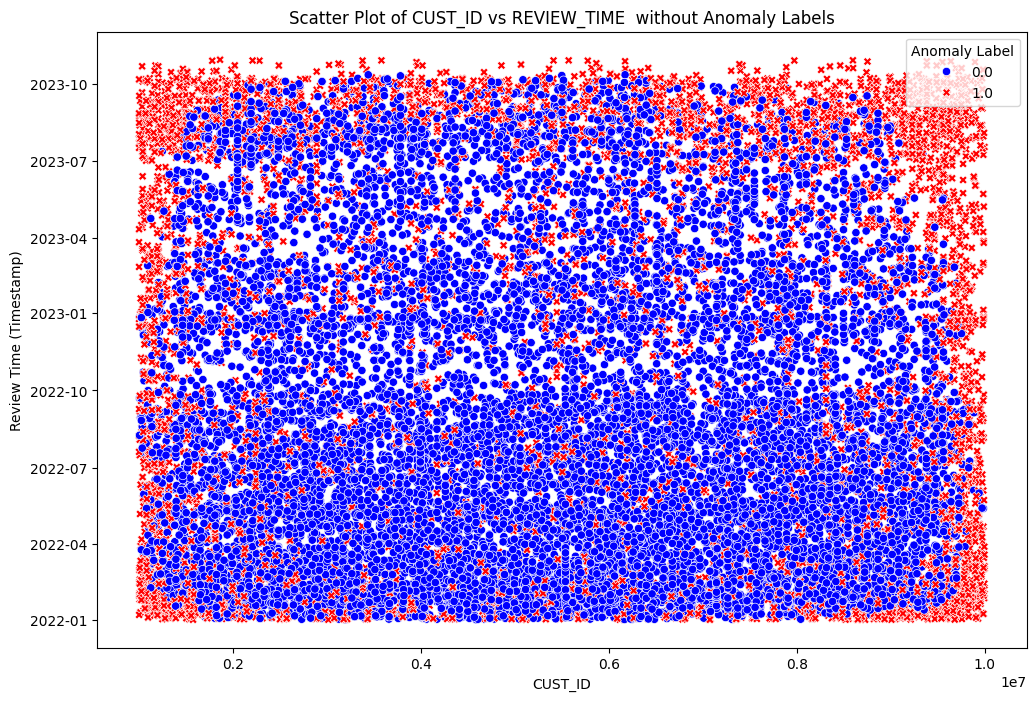

In [ ]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 - Seaborn을 전체 이용한 산점도
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='CUST_ID',
    y='REVIEW_TIME',
    hue='an_label',  # an_label에 따라 색상 구분
    style='an_label',  # an_label에 따라 스타일 구분
    palette=['blue', 'red'],  # 정상은 파란색, 이상치는 빨간색
    data=con_df
)
plt.title('Scatter Plot of CUST_ID vs REVIEW_TIME  without Anomaly Labels')
plt.xlabel('CUST_ID')
plt.ylabel('Review Time (Timestamp)')
plt.legend(title='Anomaly Label')
plt.show()

In [ ]:
# order_df=pd.read_csv('/content/drive/MyDrive/dacon_SPADA/센터데이터/0814/df_order.csv')
check_df=con_df['CUST_ID'].loc[con_df['an_label'] == 1].value_counts().head(30)
for i in check_df.index:
    print('\n\n\n')
    print(f"CUST_ID: {i}")
    print(con_df['SHOP_ID'][con_df['CUST_ID']==i].value_counts())
    print('\n\n\n')





CUST_ID: 7910390
SHOP_ID
1027285    23
5327082     2
Name: count, dtype: int64








CUST_ID: 9561730
SHOP_ID
8747429    9
9961619    7
6615025    2
5327082    1
8117291    1
7593541    1
Name: count, dtype: int64








CUST_ID: 5639506
SHOP_ID
1027285    16
5182504     3
Name: count, dtype: int64








CUST_ID: 1486496
SHOP_ID
6229161    14
1027285    10
7171326     2
8844371     2
6400206     1
6530357     1
Name: count, dtype: int64








CUST_ID: 1521645
SHOP_ID
9892265    14
2757922     1
8349554     1
2000523     1
Name: count, dtype: int64








CUST_ID: 1919552
SHOP_ID
7351266    19
4574193     1
Name: count, dtype: int64








CUST_ID: 9839713
SHOP_ID
2903295    11
6950697     3
Name: count, dtype: int64








CUST_ID: 8312370
SHOP_ID
1118545    13
2903295     3
Name: count, dtype: int64








CUST_ID: 2241345
SHOP_ID
1127521    12
2835946     4
Name: count, dtype: int64








CUST_ID: 2714388
SHOP_ID
9719359    7
9776103    5
3193048    1
6293166    1
Na

In [ ]:
order_df.loc[order_df['CUST_ID']==9385275].sort_values(by='SHOP_ID')

,SHOP_ID,ORDER_DT,CUST_ID,ORDER_ST,COMP_TIME,SHOP_CONF_TIME,CANCEL_DT,PACK_YN
268440,2089517,2022-08-05 07:08:07,9385275,완료,2022-08-05 08:08:57,2022-08-05 07:08:41,NaN,N
18882,3875663,2023-09-22 01:09:20,9385275,취소,NaN,2023-09-22 01:09:20,2023-09-22 01:09:09,N
18883,3875663,2023-09-20 08:09:08,9385275,취소,NaN,2023-09-20 08:09:08,2023-09-20 08:09:43,N
18884,3875663,2023-09-03 09:09:36,9385275,완료,2023-09-03 09:09:26,2023-09-03 09:09:12,NaN,N
18885,3875663,2023-09-12 01:09:11,9385275,완료,2023-09-12 02:09:06,2023-09-12 01:09:37,NaN,N
18886,3875663,2023-09-09 11:09:25,9385275,완료,2023-09-09 12:09:01,2023-09-09 11:09:55,NaN,N
18887,3875663,2023-09-04 09:09:32,9385275,완료,2023-09-04 09:09:12,2023-09-04 09:09:16,NaN,N
18888,3875663,2023-09-06 10:09:46,9385275,완료,2023-09-06 11:09:05,2023-09-06 10:09:18,NaN,N
342124,4338711,2022-09-11 09:09:07,9385275,완료,2022-09-11 10:09:38,2022-09-11 09:09:26,NaN,N
342125,4338711,2022-10-06 08:10:12,9385275,완료,2022-10-06 08:10:17,2022-10-06 08:10:34,NaN,N


In [ ]:
# payment_df = pd.read_csv('/content/drive/MyDrive/dacon_SPADA/센터데이터/0814/df_payment.csv')
payment_df.loc[payment_df['CUST_ID']==9385275]

,SHOP_ID,CUST_ID,PAY_GBN,TOT_AMT,DISC_AMT,DEST_PAY_GBN,CARD_PAY_GBN,CARD_APP_TIME,CARD_APP_AMT,PACK_DISC_AMT
169621,3882606,9385275,4.0,0.069138,0.043812,2.0,0.0,2022-08-06 18:23:18,0.065591,0.0
592926,6705993,9385275,4.0,0.008818,0.006683,2.0,0.0,2022-06-16 16:04:03,0.008277,0.0
592927,6705993,9385275,4.0,0.006413,0.005198,2.0,0.0,2022-06-30 18:59:47,0.005992,0.0
732723,9108986,9385275,4.0,0.045090,0.028960,2.0,0.0,2022-06-19 16:23:21,0.042745,0.0
837139,1289059,9385275,4.0,0.048096,0.030941,2.0,0.0,2022-07-02 19:10:22,0.045591,0.0


In [ ]:
con_df.loc[con_df["SHOP_ID"] == 7171326]

,SHOP_ID,CUST_ID,REVIEW_TIME,REVIEW_RANK,iso_pred,k_auto_pred,p_auto_pred,xgb_pred,auto_pred,an_label
4111,7171326,1548345,2022-06-12 01:30:27,5.0,0,1,0,1,0.0,0.0
4112,7171326,1548345,2023-08-03 19:55:44,5.0,1,1,0,1,0.0,1.0
4113,7171326,8185448,2022-03-24 21:13:02,5.0,0,1,0,1,0.0,0.0
4114,7171326,7945686,2023-09-17 22:03:49,5.0,1,1,0,1,0.0,1.0
4115,7171326,1248450,2022-01-01 17:08:33,5.0,1,0,0,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
4676,7171326,6736818,2023-08-26 23:20:55,5.0,0,1,0,1,0.0,0.0
4677,7171326,1534989,2023-09-07 16:15:40,5.0,1,1,0,1,0.0,1.0
4678,7171326,9008641,2023-09-10 19:38:05,5.0,1,1,0,1,0.0,1.0
4679,7171326,3743807,2023-09-21 23:11:45,5.0,1,1,0,1,0.0,1.0


In [ ]:
con_df.to_csv('/content/drive/MyDrive/dacon_SPADA/Modeling/total_ensemble_label.csv')